In [1]:
import cv2
import sys
import os
import matplotlib.pyplot as plt
import mediapipe as mp

# Add src to path so we can import features
sys.path.append(os.path.abspath('src'))

from features import HandPreprocessor

Extracted Features: [[np.float64(0.7597940463742474), np.float64(122.48243460747614), np.float64(170.50609610292574), np.float64(154.80164980728725), np.float64(177.55382506743547), np.float64(111.86446774006252), np.float64(161.04008645173306)]]
Number of hands detected: 1


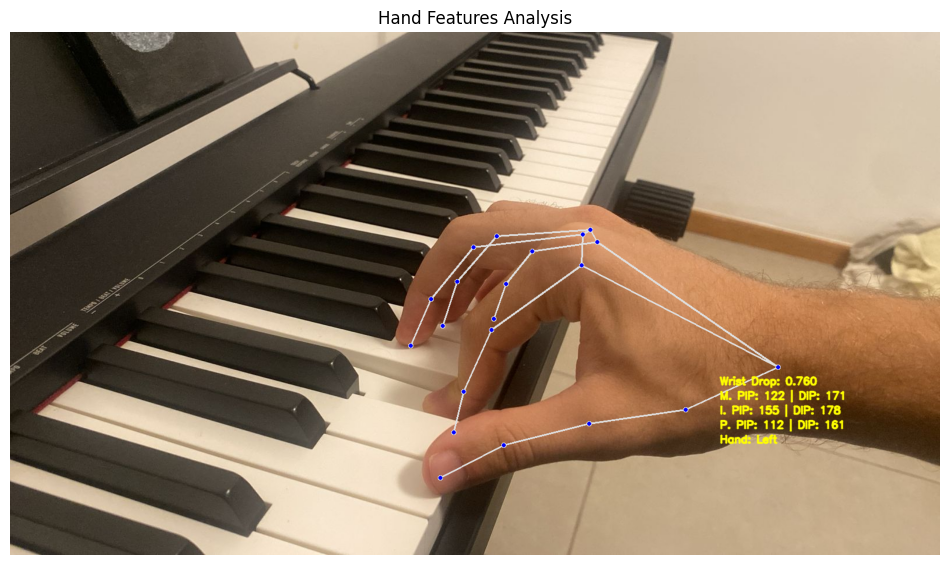

In [3]:
# Path to the image
image_path = os.path.join('data', 'images', 'collapsed1.png')

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at {image_path}. Please add the image.")
else:
    # Load image
    image = cv2.imread(image_path)
    
    if image is None:
        print("Failed to load image. Check the file format.")
    else:
        # Convert to RGB for display and MediaPipe
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Initialize preprocessor
        preprocessor = HandPreprocessor()

        # Extract features
        features = preprocessor.extract_features(image)
        print(f"Extracted Features: {features}")

        # --- Visualization ---
        # We need to re-run process to get the landmarks object for drawing,
        # or we could modify the class to return it. For this test, we re-run.
        results = preprocessor.hands.process(image_rgb)
        
        annotated_image = image_rgb.copy()
        mp_drawing = mp.solutions.drawing_utils
        mp_hands = mp.solutions.hands

        if results.multi_hand_landmarks:
            print(f"Number of hands detected: {len(results.multi_hand_landmarks)}")
            
            for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                # Draw landmarks
                mp_drawing.draw_landmarks(
                    annotated_image, 
                    hand_landmarks, 
                    mp_hands.HAND_CONNECTIONS
                )
                
                # Annotate with features if available
                if idx < len(features):
                    wrist_drop, m_pip, m_dip, i_pip, i_dip, p_pip, p_dip = features[idx]
                    
                    # Calculate text position (near the wrist)
                    h, w, _ = annotated_image.shape
                    wrist = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
                    wrist_x = int(wrist.x * w)
                    wrist_y = int(wrist.y * h)
                    
                    # Get handedness
                    if results.multi_handedness:
                        handedness = results.multi_handedness[idx].classification[0].label
                    else:
                        handedness = 'Right'
                    
                    # Prepare text
                    info_text = [
                        f"Wrist Drop: {wrist_drop:.3f}",
                        f"M. PIP: {m_pip:.0f} | DIP: {m_dip:.0f}",
                        f"I. PIP: {i_pip:.0f} | DIP: {i_dip:.0f}",
                        f"P. PIP: {p_pip:.0f} | DIP: {p_dip:.0f}",
                        f"Hand: {handedness}"
                    ]
                    
                    # Draw text background and text
                    for i, line in enumerate(info_text):
                        text_pos = (max(10, wrist_x - 100), max(20, wrist_y + 30 + (i * 25)))
                        cv2.putText(
                            annotated_image, 
                            line, 
                            text_pos, 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.6, 
                            (255, 255, 0), # Yellow
                            2, 
                            cv2.LINE_AA
                        )
        else:
            print("No hands detected for visualization.")

        # Show final image
        plt.figure(figsize=(12, 12))
        plt.imshow(annotated_image)
        plt.title("Hand Features Analysis")
        plt.axis('off')
        plt.show()